# Calculate Free Energies
Based on: https://github.com/freitas-rodrigo/FreeEnergyLAMMPS

In [1]:
from pyiron import Project

In [2]:
import numpy as np
import pandas
from jinja2 import Template
import matplotlib.pyplot as plt 
import scipy.constants as sc
from scipy.integrate import cumtrapz
import os

In [3]:
pr = Project("free")

In [4]:
pr.remove_jobs_silently(recursive=True)

In [5]:
fe_potential = pandas.DataFrame({
  'Name': ['Fe_Potential'],
  'Filename': [[os.path.abspath("Fe.eam")]],
  'Model': ['Custom'],
  'Species': [['Fe']],
  'Config': [['pair_style eam\n', 
              'pair_coeff * * Fe.eam\n']]
})

# Frenkel-Ladd thermodynamic integration

In [6]:
temperature_lst = [100, 400, 700, 1000, 1300, 1600]
alat_lst = [2.8841, 2.9115, 2.9315, 2.9484, 2.9637, 2.9782]
k_lst = [5.787, 4.866, 4.073, 3.373, 2.799, 2.443]

In [7]:
lmp_frenkel_ladd_input_str = """\
# This script runs a Frenkel-Ladd thermodynamic integration for the calculation of the free energy of bcc iron. See job.sh for the variables that need to be passed in the command line.


#--------------------------- Simulation variables -----------------------------#
  # Initalizes the random number generator.
  variable         rnd equal round(random(0,999,{{ RANDOM }}))

  # Simulation control parameters.
  variable         t_eq equal 1000 # Equilibration time.
  variable         t equal 5000 # Switching time.
#------------------------------------------------------------------------------#


#---------------------------- Atomic setup ------------------------------------#
  units            metal

  # Create atoms.
  read_data        structure.inp

  # Define interatomic potential.
  include          potential.inp
  neigh_modify     delay 0
  timestep         0.002
#------------------------------------------------------------------------------#


#----------------------------- Run simulation ---------------------------------#
  # Integrator, Frenkel-Ladd modifier, and thermostat.
  fix              f1 all nve 
  fix              f2 all ti/spring {{ k }} ${t} ${t_eq} function 2
  fix              f3 all langevin {{ T }} {{ T }} 0.1 ${rnd} zero yes

  # Compute temperature using COM coordinates.
  compute          c1 all temp/com
  fix_modify       f3 temp c1

  # Redefine simulation time to capture first and last steps on output files.
  # Notice that this does not affect the switching time.
  variable         t_eq equal ${t_eq}-1
  variable         t equal ${t}+1

  # Setup thermo output.
  thermo_style     custom step pe
  thermo           0
  variable         dE equal pe-f_f2
  variable         lambda equal f_f2[1]

  # Initial temperature to accelerate equilibration.
  variable         rnd equal round(random(1,666,0)) # Generates new rnd #.
  variable         T0 equal 2*{{ T }}
  velocity         all create ${T0} ${rnd} dist gaussian

  # Forward integration.
  run              ${t_eq}
  fix              f4 all print 1 "${dE} ${lambda}" title "# dE [eV] lambda" &
                   screen no file forward.dat
  run              ${t}
  unfix            f4

  # Backward integration. 
  run              ${t_eq}
  fix              f4 all print 1 "${dE} ${lambda}" title "# dE [eV] lambda" &
                   screen no file backward.dat
  run              ${t}
#------------------------------------------------------------------------------#
"""

In [8]:
tm_frenkel_ladd = Template(lmp_frenkel_ladd_input_str)

In [9]:
for temp, alat, k in zip(temperature_lst, alat_lst, k_lst):
    job_lmp = pr.create_job(pr.job_type.Lammps, "lmp_frenkel_ladd_" + str(temp))
    fe_bcc = pr.create_ase_bulk("Fe", a=alat ,cubic=True).repeat(5)
    job_lmp.structure = fe_bcc
    job_lmp.potential = fe_potential
    job_lmp.input.control.load_string(
        tm_frenkel_ladd.render(
            RANDOM=np.random.randint(999), 
            T=temp, 
            k=k
        )
    )
    job_lmp.run()
    job_lmp.decompress()

The job lmp_frenkel_ladd_100 was saved and received the ID: 230


/Users/jan/PycharmProjects/pyiron_mpie/pyiron/pyiron/lammps/base.py:997: UserWarning: LAMMPS warning: No dump.out output file found.
  warnings.warn("LAMMPS warning: No dump.out output file found.")
/Users/jan/PycharmProjects/pyiron_mpie/pyiron/pyiron/lammps/base.py:583: UserWarning: LAMMPS warning: log.lammps does not contain the required pressure values.
  warnings.warn("LAMMPS warning: log.lammps does not contain the required pressure values.")


The job lmp_frenkel_ladd_400 was saved and received the ID: 231
The job lmp_frenkel_ladd_700 was saved and received the ID: 232
The job lmp_frenkel_ladd_1000 was saved and received the ID: 233
The job lmp_frenkel_ladd_1300 was saved and received the ID: 234
The job lmp_frenkel_ladd_1600 was saved and received the ID: 235


In [10]:
T = np.array(temperature_lst) # [K].
a = np.array(alat_lst) # [A].
k = np.array(k_lst) # [eV/A^2].

In [11]:
m = 55.845 # Iron mass [g/mol].
natoms = len(fe_bcc) # Number of atoms.

In [12]:
natoms

250

In [13]:
kB = sc.value('Boltzmann constant in eV/K')
eV = sc.value('electron volt')
hbar = sc.value('Planck constant over 2 pi in eV s')
mu = sc.value('atomic mass constant')

In [14]:
W = np.zeros(len(T)) # Reversible work for each temperature.
for i, job in enumerate(pr.iter_jobs(convert_to_object=False)):
    if "lmp_frenkel_ladd_" in job.job_name:
        dE, lamb = np.loadtxt(os.path.join(job.working_directory, "forward.dat"), unpack=True)
        I_forw = np.trapz(dE,lamb)
        dE, lamb = np.loadtxt(os.path.join(job.working_directory, "backward.dat"), unpack=True)
        I_back = np.trapz(dE,lamb)
        W[i] = (I_forw-I_back) / 2

In [15]:
# Define harmonic reference system free energy [Eq.(15) in the paper].
omega = np.sqrt(k*eV/(m*mu)) * 1.0e+10 # [1/s].
F_harm = 3*natoms*kB*T * np.log(hbar*omega/(kB*T)) # [eV].

In [16]:
# Fixed center of mass correction [Eq.(24) in the paper].
V = (a**3/2) * natoms # Total volume.
F_CM = (kB*T)*np.log((natoms/V) * (2*np.pi*kB*T / (natoms*m*omega**2))**(3/2)) # [eV].

In [17]:
# Compute absolute free energy per atom [Eq.(16) in the paper] and save data.
F_fl = (F_harm + W + F_CM) / natoms # [eV/atom].
T_fl = T.copy()

In [18]:
c = ['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999']

Text(0, 0.5, 'Free energy [eV/atom]')

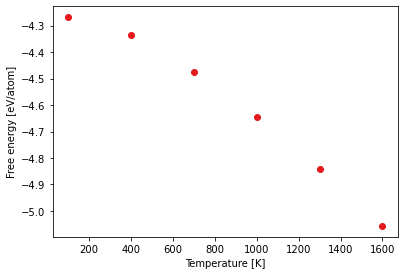

In [19]:
# Start figure.
fig = plt.figure()
ax = fig.add_axes([0.15,0.15,0.80,0.80])

# Plot.
ax.plot(T_fl, F_fl, 'o', c=c[0], lw=1)
 
# Add details and save figure.
ax.set_xlabel(r'Temperature [K]')
ax.set_ylabel(r'Free energy [eV/atom]')

# Reversible Scaling thermodynamic integration

In [20]:
reversible_scaling_input_str = """\
# This script runs a Reversible Scaling thermodynamic integration for the calculation of the temperature dependence of the free energy of bcc iron. See job.sh for the variables that need to be passed in the command line.


#--------------------------- Simulation variables -----------------------------#
  # Initalizes the random number generator.
  variable         rnd equal round(random(0,999,{{ RANDOM }}))

  # Simulation control parameters.
  variable         t_eq equal 1000 # Equilibration time.
  variable         t equal 10000 # Switching time.
  variable         T equal 100 # Simulation temperature.
#------------------------------------------------------------------------------#


#---------------------------- Atomic setup ------------------------------------#
  units            metal

  # Create atoms.
  read_data        structure.inp

  # Define Interatomic potential.
  include          potential.inp
  neigh_modify     delay 0
  timestep         0.002
#------------------------------------------------------------------------------#


#----------------------------- Run simulation ---------------------------------#
  # Setup thermo output.
  thermo_style     custom step pe
  thermo           0

  # Integrator for barostat and thermostat.
  fix              f1 all nph iso 0 0 1
  fix              f2 all langevin ${T} ${T} 0.1 ${rnd} zero yes

  # Compute temperature using center-of-mass coordinates.
  compute          c1 all temp/com
  fix_modify       f1 temp c1
  fix_modify       f2 temp c1

  # Initial temperature to accelerate equilibration.
  variable         rnd equal round(random(0,666,0)) # Generates new rnd #.
  variable         T0 equal 2*${T}
  velocity         all create ${T0} ${rnd} dist gaussian

  # Forward integration.
  run              ${t_eq}
  print            "$(pe/atoms) 1" file forward.dat
  variable         lambda equal 1/(1+(elapsed/${t})*({{ t_max }}/$T-1))
  fix              f3 all adapt 1 pair eam scale * * v_lambda
  fix              f4 all print 1 "$(pe/atoms) ${lambda}" screen no &
                   append forward.dat title "# pe lambda"
  run              ${t}
  unfix            f3
  unfix            f4

  # Backward integration. 
  run              ${t_eq}
  print            "$(pe/atoms) $(v_T/{{ t_max }})" file backward.dat
  variable         lambda equal 1/(1+(1-(elapsed/${t}))*({{ t_max }}/$T-1))
  fix              f3 all adapt 1 pair eam scale * * v_lambda
  fix              f4 all print 1 "$(pe/atoms) ${lambda}" screen no &
                   append backward.dat title "# pe lambda"
  run              ${t}
#------------------------------------------------------------------------------#
"""

In [21]:
alat = 2.8841

In [22]:
tm_reversible_scaling = Template(reversible_scaling_input_str)

In [23]:
job_reversible_scaling = pr.create_job(pr.job_type.Lammps, "lmp_reversible_scaling")
fe_bcc = pr.create_ase_bulk("Fe", a=alat ,cubic=True).repeat(5)
job_reversible_scaling.structure = fe_bcc
job_reversible_scaling.potential = fe_potential
job_reversible_scaling.input.control.load_string(
    tm_reversible_scaling.render(
        RANDOM=np.random.randint(999),
        t_max=temperature_lst[-1]
    )
)
job_reversible_scaling.run()
job_reversible_scaling.decompress()

The job lmp_reversible_scaling was saved and received the ID: 236


/Users/jan/PycharmProjects/pyiron_mpie/pyiron/pyiron/lammps/base.py:997: UserWarning: LAMMPS warning: No dump.out output file found.
  warnings.warn("LAMMPS warning: No dump.out output file found.")
/Users/jan/PycharmProjects/pyiron_mpie/pyiron/pyiron/lammps/base.py:583: UserWarning: LAMMPS warning: log.lammps does not contain the required pressure values.
  warnings.warn("LAMMPS warning: log.lammps does not contain the required pressure values.")


In [24]:
T0 = 100 # Reference temperature [K]
kB = sc.value('Boltzmann constant in eV/K') 

In [25]:
F0 = F_fl[T==T0]

In [26]:
U_f, lamb_f = np.loadtxt(os.path.join(job_reversible_scaling.working_directory, "forward.dat"), unpack=True)
U_b, lamb_b = np.loadtxt(os.path.join(job_reversible_scaling.working_directory, "backward.dat"), unpack=True)

In [27]:
# Fix adapt also scales the potential energy besides the forces, so we unscale.
U_f /= lamb_f
U_b /= lamb_b

In [28]:
# Compute work done using cummulative integrals [Eq.(21) in the paper].
I_f = cumtrapz(U_f,lamb_f,initial=0)
I_b = cumtrapz(U_b[::-1],lamb_b[::-1],initial=0)
W = (I_f+I_b) / (2*lamb_f)

In [29]:
# Compute free energy [Eq.(22) in the paper] and save results.
T_rs = T0 / lamb_f
F_rs = F0/lamb_f  + 1.5*kB*T_rs*np.log(lamb_f) + W

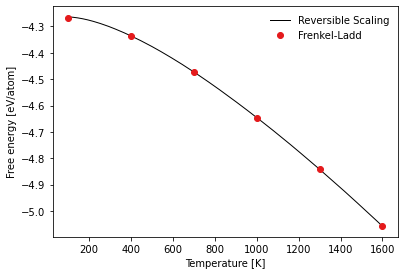

In [30]:
# Start figure.
fig = plt.figure()
ax = fig.add_axes([0.15,0.15,0.80,0.80])

# Plot.
ax.plot(T_rs, F_rs, '-', c='k', lw=1, label='Reversible Scaling')
ax.plot(T_fl, F_fl, 'o', c=c[0], label='Frenkel-Ladd')
 
# Add details and save figure.
ax.set_xlabel(r'Temperature [K]')
ax.set_ylabel(r'Free energy [eV/atom]')
ax.legend(loc='best', frameon=False)